# Dynamic Programming Approach to Leniency Policies in Collusive Corruption

This Notebook builds an economic model of non-trial resolutions for collusive corruption. It uses discrete time and discrete state dynamic programming to solve the agents' decision problem.

## Overview

    1) Settle the Basic Model, the relevant constants and variables; 

    2) Build the Transition functions;

    3) Build the Reward Function;

    4) Find the optimal policy from **one player** given a greedy policy from the other player; and

    5) Use optimal policicies found and iterate until convergence.


In [1]:
# # check matplotlib version.... ax.bar_label is available only in the 3.5+
# !pip install quantecon
#!pip install matplotlib -U

In [2]:
import numpy as np
import quantecon as qe
import scipy.sparse as sparse
from quantecon import compute_fixed_point
from quantecon.markov import DiscreteDP
from datetime import datetime
import matplotlib.pyplot as plt


Bad key text.latex.preview in file c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jp

In [3]:
# %load_ext itikz

In [4]:
# !mkdir Plottings

# #if colab:
# !wget https://raw.githubusercontent.com/caxaxa/Corruption_Game/main/Plotting_Functions.ipynb
# !wget https://raw.githubusercontent.com/caxaxa/Corruption_Game/main/Tests.ipynb




%run Plotting_Functions.ipynb  #Notebook with the plotting functions created for these specific outputs
%run Tests.ipynb  #Notebook with tests from the code


### Constants

Given the following constants $\theta$ for all periods $t$ and all agents $i \in (payer,receiver)$:


* Let $b$ be the fixed price of the bribes;

* Let $a$ be the gains from corruption to the payer;

* The cost from perfoming the corruption favour from the bribe receiver is $c_r$ ;

* Let $f$ be the monetary fines for agents caught in corruption;

* $i$ is the interest rate;

* $\delta$ is the liability depreciation or prescription;

* $\gamma$ is the time discount;

* $\eta$ is the agents' risk aversion;

* $y_0$ is an autonomous non-financial income;

* Probability of detection is $\alpha$; and

* Probability of conviction is $\beta$.

#### Leniency rules:

* $R$ sanction reduction for unilateral self-reporting before detection;

* $r$ sanction reduction for simultaneously self-reporting before detection;

* $P$ sanction reduction for unilateral self-reporting after detection; and

* $p$ sanction reduction for simultaneously self-reporting after detection.



In [5]:

#Constants are in globals

b = 2 # Bribe
a = 7 # Advantage From Corruption
c_b = 0 # Cost of Corrutpion for the receiver
f = 5 # Fine for corruption

alpha = 0.2 # Probability of detection from authorities
beta = 0.6 # Probability of judicial conviction

ir = 0.1 # Interest Rates
delta = 0.2 # Liability Depreciation

gamma = 0.98 # Time discount
eta = 0.9 # Risk Aversion


y0 = 0 # Non-financial income
yl = b #leaving wage


# Defining the constants of sanction reduction
R = 0

r = 0.6

P = 0.75

p = 0.9


# Defining the players in the instance

player = 'payer'

In [6]:
def get_otherplayer(player):
    if player == 'payer':
        return 'receiver'
    else:
        return 'payer'

### States and Actions:

This example is built using discrete time, decisions and states:

#### A set of discrete actions or decisions (controls)  $\mathbf{d}_{i,t}$

The decision regarding corruption $d{i,t}$ can assume 3 different values:

* $not_{i,t}$ agents can choose to do nothing; 

* $cor_{i,t}$ is the decision from player $i$ to pay/receive a bribe in time $t$; and

* $rep_{i,t}$ is the decision from player $i$ to self-report.

Agents decide how much they are going to consume at each time $c_t$.
A complementary way to represent the consumpion decision, is the decision of how much to save $w$, or buy financial assets.

* $w_{i,t}$ is the decision of how much to save, can go from 0 to $(W_t)$

#### A set of discrete states  $\textbf{x}_{i,t}$

##### State of the world $S$

* $S_{i,t}$ is the state of the world at time $t$;

* $s_{nc}$ is the state of the world where neither players are in corruption;

* $s_{cor}$ is the state of the world where both agents succeded in corruption;

* $s_{det,i}$ is the state of the world where the agent $i$ is detected for corruption;

* $s_{con,i}$ is the state of the world where the agent $i$ is convicted;

* $s_{acq,i}$ is the state of the world where the agent $i$ is acquitted;

* $s_{sr,i}$ is the state of the world where the agent $i$ self-reported before being detected;

* $s_{pg,i}$ is the state of the world where the agent $i$ plead guilty;

and

* The states of the world $( s_{nc}, s_{cor}, s_{det,i}, s_{col,i}, s_{con,i},s_{acq,i}, s_{sr,i}, s_{pg,i}) \in S$;

##### Wealth from Players

* $W_{i,t}$ are the assets from player $i$ at time $t$. It goes from 0 to a maximum of $\overline{W}$;

##### Liability from Players

* $L_{i,t}$ is the wealth from player $i$ at time $t$. It goes from 0 to a maximum of $\overline{L}$;

#### State and Action 

* Lastly, the states $( W_{i,t}, L_{i,t},S_{i,t}) \in \textbf{x}_{i,t}$ and the actions $(d_{i,t},w{i,t}) \in \mathbf{d}_{it}$.

In summary:
$
\begin{equation*}
	\mathbf{d}_{t} \equiv
	\begin{bmatrix}
		d_{t} \\
		w_{t} \\  
	\end{bmatrix}\textrm{, and }
	\mathbf{x}_{t}\equiv
	\begin{bmatrix}
		W_{t}\\
		L_{t}\\
		S_{t}
	\end{bmatrix}
\end{equation*}
$
### State and Action Spaces

Let $\mathbf{x}$ be the entire state-space. If,

$W \in [0,...,\bar{W}]$,

$L \in [0,...,\bar{L}]$, and

$S \in [s_{nc},s_{cor},s_{des},s_{det},s_{con},s_{acq},s_{sr},s_{pg}]$,

then,

$ \mathbf{x} = [W,L,S] $ and has dimention $(3 \times (\bar{W}*\bar{L}*8))$.

* Let $\mathbf{d}$ be the entire action or control-space. If,

$d \in [not_{i,t},cor_{i,t},rep_{i,t}]$ and

$a = [0,...,\bar{W}]$, then

$ \mathbf{d} = [a,d] $ and has dimention $(2 \times (\bar{W}*3))$.

In [7]:
#maximun wealth from corruption:
W_bar = 10

#create the wealth statespace:
W_space = np.arange(0,W_bar+1)

#maximum liability
L_bar = 5

#create the wealth statespace:
L_space = np.arange(0,L_bar+1)

#creat the actionspace:
# It is better to identify all decisions in one column than having a column to each binary decision. Because:
# 1 - It enhances readibility;
# 2 - Imply that agents cannot make two decisions in the same state; and
# 3 - It makes no difference in the lenth of the feasible action-space.
d_not = 0 # do nothing
d_cor = 1 # pay a bribe
d_rep = 2 # report a crime

d_space = np.array([d_not,d_cor,d_rep])

#create the saving space:
w_space =  np.arange(0,W_bar+1)

# state of the world space
# It is better to use integers as ids so the arrays for the state-spaces preserve integer as the main data type. 
s_nc  = 0
s_cor = 1
s_det = 2
s_des = 3
s_con = 4
s_acq = 5
s_sr = 6
s_pg = 7

S_space = np.array([s_nc,s_cor,s_det,s_des,s_con,s_acq,s_sr,s_pg])

### Output from states an Actions (Payoffs)

#### Returns from Corruption 

It is possible to write the corruption in terms of payoffs $\pi_{i,t+1}(d)$ and costs $\phi_{i,t}(d)$ for players.

Or else, if players choose to pay a bribe then:

$\pi_{payer} = a$ and, $\pi_{receiver} = b$. 

Also, $\phi_{payer} = b$ and, $\phi_{receiver} = c_{b}$.

Moreover, the cost and the return for players from not entering in bribery is 0.

In [8]:
#Cost and return functions
def get_pi_i(player, Si):#return from bribery
    if Si == s_cor: ## substitute by the function S_prime to get pi_prime of d_t.
        if player == 'payer':
            return a
        else:
            return b
    else:
        return 0

    
def get_phi_i(player, di,dj): #cost from bribery
    if di == 1 and dj == 1:
        if player == 'payer':
            return b
        else:
            return c_b
    else:
        return 0

#### Criminal liability $l$

Agents are liable for each crime $l_t$ they commited. 

Each bribe paid generates a criminal liability $l$ in the next period.

Nonetheless, liability from crimes tend to depreciate at a rate $\delta$ over time. 

The history of the liabilities is expressed by the state $L_t$ each period.

$l_{t}(d) = \begin{cases}
	1 \textrm{   if colluding and } d_{t} = 1 \\
	-1 \textrm{   if desisted and } d_{t} = 0 \\
    0 \textrm{  else}\end{cases}$




In [9]:
# liability from crimes
def get_li_prime(di, dj, S_prime):
    if S_prime == s_des:
        return -1
    elif di == 1 and dj == 1:
        return 1
    else:
        return 0
    


#### Sanctions $s$

If agents are convicted for corruption ($s_{con}$), they pay a monetary $s$.

The sanction depends on the fine $f$ for each crime that they are liable at that time $L_t$.

If agents, decide do self-report their misconducts before being detected they recieve a reduction from the sanction.

The reduction is $R$ if they unilaterealy report, or $r$ if they report together.

If agents, decide do self-report their misconducts after being detected they recieve a reduction from the sanction.

The reduction is $P$ if they unilaterealy report, or $p$ if they report together.


In [10]:
#sanction from crimes
def get_si(Li ,Si,Sj):
    if Li == 0:
        return 0
    elif Si == s_con:
        return f*Li + (get_pi_i(player,1)/(gamma**(Li*2)))*(Li-1)  # discounted gain from corruption
    elif Si == s_sr:
        if Sj == s_sr:
            return r*f*Li + (get_pi_i(player,1)/(gamma**(Li*2)))*(Li-1)
        else:
            return R*f*Li + (get_pi_i(player,1)/(gamma**(Li*2)))*(Li-1)
    elif Si == s_pg:
        if Sj == s_pg:
            return p*f*Li + (get_pi_i(player,1)/(gamma**(Li*2)))*(Li-1)
        else:
            return P*f*Li + (get_pi_i(player,1)/(gamma**(Li*2)))*(Li-1)
    else:
        return 0


#### Financial Income $y_f$:

Financial income $y_f$ is given by the interest rates $r$ over the savings $w$.

#### Corruption Income $y_c$:


Now it is possible to define the agents income.

At each period $t$ the agents $i$ have an income that depends on their current state:


For $y_c \in (0,\pi,s,Rs,rs,Ps,ps)$ let,

$y_{c ~ t}(\mathbf{x}_t) = \begin{cases}
	0\textrm{   if not colluding}\\
	\pi \textrm{   if colluding}\\
	0\textrm{   if desisted} \\
	 s\textrm{   if Convicted } \\
	0 \textrm{ if Acquitted } \\
    Rs \textrm{ if Reported alone before detection } \\
    rs \textrm{ if reported simultaneously before detection}\\
    Ps \textrm{ if Reported alone after detection } \\
    ps \textrm{ if reported simultaneously after detection}
	\end{cases}$.
    
    
Lastly, $W_t = y_0+ y_f + y_c$

In [11]:
# Income        
def get_yfi_prime(w):
    return int(round((1 + ir)*w))

def get_yfc_prime(player, L_prime, Si_prime, Sj_prime):
    return get_pi_i(player, Si_prime) - get_si(L_prime, Si_prime, Sj_prime)

    
#### Expected return

$$ - \phi + \gamma E \left[ \sum_{\mathbf{x}} (\pi - s) \right] $$

It is convenient to define the expected return from corruption. Or else, the return $y_{c ~ t}$ that agents expect to have given their state $\mathbf{x_t}$ and decisions $\mathbf{d_t}$.

$$E\left[ y_{c~ i,t} | \mathbf{x}_{i,t},\mathbf{d}_{i,t} \right] = E\left[-\phi_{i,t}(d_{i,t},d_{j,t}) \right]+ E\left[\pi_{i,t+1}(di,dj) \right]+ E\left[ s_{i,t+1}(L_{i,t+1},di,dj)\right]$$

For exemple, if $d_i = d_{cor}$ and $d_j = d_{cor}$:

$$E\left[ y_{c ~ i,t} | \mathbf{x}_{i,t},\mathbf{d}_{i,t} \right] = -\phi_{i,t}(d_{i,t},d_{j,t}) + (1+\alpha)\pi_{i,t+1}(di,dj) + \alpha \beta s_{i,t+1}(L_{i,t+1},di,dj)$$


In [12]:
# Expected retrun next period from corruption.
def expected_return_i(player, L_prime, W_prime):
    return - get_phi_i(player, d_cor , d_cor) + gamma *((1-alpha)*get_pi_i(player, s_cor) + alpha*beta*get_si(L_prime, s_con , s_con))

### Laws of motion

$$\mathbf{x}_{t+1} = x ( \mathbf{x}_t , \mathbf{d}_t , \varepsilon_{t+1} ; \theta ) $$

Where $\theta$ is a vector of constant parameters.

And $\varepsilon \sim Bernoulli ~ (\alpha)$



#### Wealth transition rule
In this specific example we have:

$$W_{i,t+1} = y_{f ~ i,t+1}  + y_{c ~ i,t+1} + y_0 $$

where,

$$ y_{f ~ i,t+1}  = (1+r)w_{i,t}$$ or,

$$ w_{i,t}  = W_{i,t} - c_{i,t} - \phi{i,t} $$

Since wealth increases because of income. Be it from, financial investments, corruption or non-financial income.


In [13]:

# What is not saved is totally consumed in t or paid in phi
def get_Wi_prime(player, wi, L_prime, Si_prime, Sj_prime):
    if y0 + get_yfi_prime(wi) + get_yfc_prime(player, L_prime, Si_prime, Sj_prime) > yl:
        if y0 + get_yfi_prime(wi) + get_yfc_prime(player, L_prime, Si_prime, Sj_prime) <= W_bar:
            return int(round(y0 + get_yfi_prime(wi) + get_yfc_prime(player, L_prime, Si_prime, Sj_prime)))
        else:
            return W_bar
    elif y0 + get_yfi_prime(wi) + get_yfc_prime(player, L_prime, Si_prime, Sj_prime) > 0:
        return int(round(y0 + get_yfi_prime(wi) + get_yfc_prime(player, L_prime, Si_prime, Sj_prime))) + yl  
    else:
        return yl ### or y0 -> Depends on the hypothesis... if Wi is negative the players use or not the y0 to pay the Fines

#### Liability transition rule

$$L_{i,t+1} = (1-d)L_{i,t} + l_{i,t+1} $$

Liability decays over time. Because information gets lost over time and also because of prescripion rules.

In [14]:
def get_Li_prime(Li,di,dj,Si_prime):
    if Si_prime == s_nc: # There are no Liabilities after judgments
        return 0
    elif ((Li + get_li_prime(di, dj,Si_prime) > 0) and (Li + get_li_prime(di, dj,Si_prime) <= L_bar)) :
        return Li + get_li_prime(di, dj, Si_prime)
    elif Li + get_li_prime(di, dj,Si_prime) > L_bar :
        return L_bar
    else:
        return 0
    
################################### no decrease after 2

$$S_{t+1} = S(\varepsilon, S_t|d_t) $$

The transition rule for $s$ is better represented by the diagram bellow:

In [15]:
# %%itikz
# \documentclass[tikz]{standalone}
# \begin{document}


# \usetikzlibrary{decorations.pathreplacing,angles,quotes,calc,positioning,plotmarks}
# \usetikzlibrary{shapes.geometric, arrows, automata,arrows,positioning,calc}
# \tikzstyle{startstop} = [rectangle, rounded corners, minimum width=3cm, minimum height=1cm,text centered, draw=black]
# \tikzstyle{io} = [trapezium, trapezium left angle=70, trapezium right angle=110, minimum width=3cm, minimum height=1cm, text centered, draw=black]
# \tikzstyle{process} = [rectangle, minimum width=3cm, minimum height=1cm, text centered, draw=black]
# \tikzstyle{decision} = [diamond, minimum width=3cm, minimum height=1cm, text centered, draw=black]
# \tikzstyle{arrow} = [thick,->,>=stealth]

# \begin{tikzpicture}[->, >=stealth', auto, semithick, node distance=2cm]
# 		\tikzstyle{every state}=[fill=white,draw=black,thick,text=black,scale=1]
# 		\node[state]    (A)        		       {No Corrup.};
# 		\node[state]    (B)[above right of= B]  at (2.5,2)	     	 {Detected};
# 		\node[state]    (C)[below right of= B]	at (2.5,-1.5)	         {Colluding};
# 		\node[state]    (D)[right of= B]  at (6,0)				 { Desisted };
# 		\node[state]    (E)[right of= B]  at (2,0)				 { Convicted };
# 		\node[state]    (F)[right of= B]  at (2,-6)				 { Collab. };
# 		\path
# 		(A) edge[loop left, left]	    	         node{1}   		        (A)
# 		(A) edge[bend right,below]    			     node{2}        		(C)
# 		(A) edge[right,below]    			         node{3}        		(B)                     
# 		(C) edge[loop below, above]    				 node{4}            	(C)                  
# 		(C) edge[very near end,bend left, right]   	 node{5}            	(B)
# 		(B) edge[bend right,above]    				 node{6*}            	(A)
# 		(C) edge [bend right,below]             	 node{7}                (D)
# 		(D) edge [bend right,above]     	         node{8}                (C)
# 		(D) edge[loop right]	      				 node{9}                (D)
# 		(D) edge[bend right,above]    				 node{10}            	(B)
# 		(D) edge [above]    						 node{11}            	(E)
# 		(B) edge    								 node{12}            	(E)
# 		(C) edge    								 node{13}            	(E)
# 		(B) edge[very near end,bend right,left]      node{14}               (F)                    
# 		(D) edge[bend left]                			 node{15}               (F)
# 		(C) edge[bend left]                			 node{16}               (F)
# 		(F) edge[bend left]                			 node{17}               (A)
# 		(E) edge[above]                  			 node{18}               (A);
# 	\end{tikzpicture}
# \end{document}

                    

### State Transition Rule for S(x'|x,d)

1) If no bribe is paid, the agent stays in the state not corruption. They can agree in corruption only if both parties join.: 

* $p(x' = s_{nc} | x = s_{nc}, d_i = 0 ~ or ~  d_j = 0) = 1$

2) Agents go from not no corruption to corruption when they pay bribe with probability (1 - $\alpha$) 

* $p(x' = s_{cor} | x = s_{nc}, d_i = 1 ~ and ~ dj_1) = 1 - \alpha$

3) If agents pay a bribe they can go from no corruption to detected with probability ($\alpha$)

* $p(x' = s_{det} | x = s_{nc}, d_i = 1 ~ and ~ d_j=1 ) = \alpha$

4) Agents stay in corruption if they keep paying bribes with probability  (1 - $\alpha$) 

* $p(x' = s_{cor} | x = s_{corr}, d_i = 1 ~ and ~ d_j=1) = 1 - \alpha$

5) If agents pay a bribe they can go from corruption to detected with probability ($\alpha$)

* $p(x' = s_{det} | x = s_{nc}, d_i = 1 ~ and ~ d_j=1) = \alpha$

6) * If agents are detected and they do not plea guilty, they are acquitted with probability $(1-\beta)$. After, they go back to the state with no corrution.

* $p(x' = s_{acq} | x = s_{cor}, d_i = 0 ~ and ~ d_j = 0) = 1 - \beta$

* $p(x' = s_{nc} |  x = s_{acq}) = 1 $

7) Agents can desist from corruption if they stop paying bribes;

* $p(x' = s_{des} | x = s_{cor}, d_i = 0 ~ and ~ d_j = 0) = 1 - \alpha$

8) If agents pay bribes again, and they succed, they go back to corruption state;

* $p(x' = s_{des} | x = s_{cor},d_i = 1 ~ and ~ d_j=1) = 1 - \alpha$

9) If agents still not paying bribes they stay at desist state if they are not detected;

* $p(x' = s_{des} | x = s_{des},  d_i = 0 ~ and ~ d_j = 0) = 1 - \alpha$

10) If agents pay bribes again, and are detected, they go to detected state;

* $p(x' = s_{det} | x = s_{cor}, d_i = 1 ~ and ~ dj_ = 1) = \alpha$

11) If agents are reported, they are convicted for sure;

* $p(x' = s_{des} | x = s_{con}, d_i \neq 2 ~ and ~d_j = 2 ) = \alpha$

12) If agents are detected and do not plea guilty, they are convicted if the other agent report or if they not repor with probability $\beta$;

* $p(x' = s_{con} | x = s_{det}, d_i \neq 2 ~ and ~d_j \neq 2 ) = \beta$

* $p(x' = s_{con} | x = s_{det}, d_i \neq 2 ~ and ~d_j = 2 ) = 1$

13) If agents are reported they are convicted with certainty;

* $p(x' = s_{con} | x = s_{cor}, d_i \neq 2 ~ and~ d_j = 2 ) = 1$

14) If agents plea guilty they will be collaborating with certainty;

* $p(x' = s_{col} | x = s_{det}, d_i = 2) = 1$

15) If agents report their crimes they will be collaborating with certainty;

* $p(x' = s_{col} | x = s_{des}, d_i = 2) = 1$

16) If agents report their crimes they will be collaborating with certainty;

* $p(x' = s_{col} | x = s_{cor}, d_i = 2) = 1$

17) After collaborating with autorities, agents are back to the stage of non corruption;

* $p(x' = s_{nc} | x = s_{col}) = 1$

18) After convicted by autorities, agents are back to the stage of non corruption;

* $p(x' = s_{nc} | x = s_{con}) = 1$


In [16]:
#Translate all rules into if statements:

def rule_1(Si,di,dj):
    if Si == s_nc and (di == d_not or dj == d_not): #s_nc , 1
        return True
    else:
        return False 
    
def rule_2(Si,di,dj):
    if Si == s_nc and (di == d_cor and dj == d_cor): #s_cor# , 1 - alpha
        return True
    else:
        return False 
    
def rule_3(Si,di,dj):
    if Si == s_nc and (di == d_cor and dj == d_cor): # s_det #, alpha
        return True
    else:
        return False
    
def rule_4(Si,di,dj):
    if Si == s_cor and (di == d_cor and dj == d_cor): #s_cor #, 1 - alpha
        return True
    else:
        return False 
    
def rule_5(Si,di,dj):
    if Si == s_cor and (di == d_cor or dj == d_cor) and (di != d_rep and dj != d_rep): # s_det# , alpha
        return True
    else:
        return False 
    
def rule_6_1(Si,di,dj): # s_nc# , 1
    if Si == s_acq:
        return True
    else:
        return False 
    
def rule_6_2(Si,di,dj):    
    if Si == s_det and (di == d_not and dj == d_not): # s_acq# , 1 - beta
        return True
    else:
        return False 
    
def rule_7(Si,di,dj):
    if Si == s_cor and (di == d_not or dj == d_not) and (di != d_rep and dj != d_rep):# s_des# , 1 - alpha
        return True
    else:
        return False 

def rule_8(Si,di,dj):
    if Si == s_des and (di == d_cor and dj == d_cor):# s_cor# , 1 - alpha
        return True
    else:
        return False 

def rule_9(Si,di,dj):
    if Si == s_des and (di == d_not or dj == d_not) and (di != d_rep and dj != d_rep):# s_des# , 1 - alpha
        return True
    else:
        return False 
    
def rule_10(Si,di,dj):
    if Si == s_des and (di != d_rep and dj != d_rep):# s_det# , alpha
        return True
    else:
        return False 
    
def rule_11(Si,di,dj):
    if Si == s_des and (di == d_not or di == d_cor) and dj == d_rep:# s_con # , 1 
        return True
    else:
        return False
    
def rule_12(Si,di,dj):
    if Si == s_det:
        if (di == d_not and dj == d_not):#  s_con # , beta
            return True
        elif (di == d_not and dj ==d_rep):# s_con #, 1
            return True
        else:
            return False  
        
def rule_13(Si,di,dj):
    if Si == s_cor and (di == d_not or di == d_cor) and dj == d_rep:# s_con # , 1 
        return True
    else:
        return False  
    
def rule_14(Si,di,dj):
    if Si == s_det and di == d_rep:# s_pg # , 1 
        return True
    else:
        return False   
    
def rule_15(Si,di,dj):
    if Si == s_des and di == d_rep:# s_sr # , 1 
        return True
    else:
        return False  
    
def rule_16(Si,di,dj):
    if Si == s_cor and di == d_rep:# s_sr # , 1
        return True
    else:
        return False  

def rule_17(Si,di,dj):
    if Si == s_sr or Si == s_pg:# s_nc# , 1
        return True
    else:
        return False 
    
def rule_18(Si,di,dj):# s_nc# , 1
    if Si == s_con:
        return True
    else:
        return False 

# Each future state has a unique probability to be achieved
def get_prob(Si_prime, Sj_prime ):
    if Si_prime == s_nc or Si_prime == s_sr or Si_prime == s_pg or Sj_prime == s_sr or Sj_prime == s_pg :
        return 1
    elif Si_prime == s_cor or Si_prime == s_des:
        return 1 - alpha
    elif Si_prime == s_det:
        return alpha
    elif Si_prime == s_con and Sj_prime == s_con:
        return beta
    elif Si_prime == s_acq:
        return 1 - beta
    
# Each future statement is feasible from a set of rules:
#The following set of functions 

def get_Si_prime(Si,di,dj):
    Si_prime = []
    if rule_1(Si,di,dj) or rule_6_1(Si,di,dj) or rule_17(Si,di,dj) or rule_18(Si,di,dj):
        Si_prime.append(s_nc)
    if rule_2(Si,di,dj) or rule_4(Si,di,dj) or rule_8(Si,di,dj):
        Si_prime.append(s_cor)
    if rule_7(Si,di,dj)  or rule_9(Si,di,dj):
        Si_prime.append(s_des)
    if rule_3(Si,di,dj) or rule_5(Si,di,dj) or rule_10(Si,di,dj):
        Si_prime.append(s_det)
    if rule_11(Si,di,dj) or rule_12(Si,di,dj) or rule_13(Si,di,dj):
        Si_prime.append(s_con)
    if rule_6_2(Si,di,dj):
        Si_prime.append(s_acq)
    if rule_15(Si,di,dj) or rule_16(Si,di,dj):
        Si_prime.append(s_sr)
    if rule_14(Si,di,dj):
        Si_prime.append(s_pg)
    return Si_prime
    
    

### Objective Function

$$ \max E_0 \sum^{\infty}_{t=0} \gamma^t u( c_{t}) $$



It is possible to define consumption $c_t$ in a certain period as the leftover from consumption:



Therfore $u(.)$ is a CCRA function, where;

$$u(c) = \frac{\displaystyle c ^{(1-\eta)} - 1 } {1-\eta} $$

Where $\eta$ is the risk aversion parameter. Where $\eta > 0$ represents some degree of risk aversion.

It is also possible to write $c_t$ as a function of $\mathbf{x}_{i,t},\mathbf{d}_{i,t}$:

$$ c_t = W_t - w_t - \phi_t $$

In [17]:
# Define the consumption function:
def get_ci(Wi,wi,phi):
    return Wi - wi - phi

# Define the utility Function

def u(c):
    if eta != 1:
        return (c**(1-eta)-1)/(1-eta)
    else:
        return ln(c) #import ln function

### The agent's problem:


$$ \max E_0 \sum^{\infty}_{t=0} \gamma^t u( c_{t}) $$

s.t.

$$W_{i,t+1} = (1+r)w_{i,t} + y_{i,t+1}$$
$$L_{i,t+1} = (1-d)L_{i,t} + l_{t+1} $$
$$S_{t+1} = f(\varepsilon, S_t|d_t) $$

where, $w_{i,t} =W_t - c_t -\phi_t$


It is possible to rewrite the agent's problem as a value function, such as:

$$V(\mathbf{x}) = \max_{\mathbf{x},\mathbf{x'},\mathbf{d}} \{ u(\mathbf{x}) + \gamma E[V(\mathbf{x'})|\mathbf{x},\mathbf{d}]\}$$

This is called the Bellman Equation and it is quivallento to:

$$V(\mathbf{x}) = \max_{\mathbf{x},\mathbf{x'},\mathbf{d}} \{ R(\mathbf{x},\mathbf{d}) + \gamma V(\mathbf{x'}) \Omega(\mathbf{x'},\mathbf{d},\mathbf{x})\}$$


This problem can be solved by iterating the matrix $\Omega$ through the reward function $R$.

Note that the controls $\mathbf{d}$ which solve the Bellman equation is a pair of decisions. This pair of decisions must hold at the optimum level.

So, to solve for the pair or decisions $\mathbf{d}$, first, we calculate the optimum policy for the payer $\sigma_{payer}$ using the receiver policy $\sigma_{receiver}$ as a greedy policy. Such that, 

 \begin{equation}
	\sigma(\mathbf{x}) \in \max_{\mathbf{x},\mathbf{x'},\mathbf{u}} \{ u(\mathbf{x}) + \delta \sum_{\mathbf{x}}  V^*(\mathbf{x'})\Omega(\mathbf{x'},\mathbf{u},\mathbf{x})\}
	\label{v4}
\end{equation}

The quantecom package DiscreteDP was used to calculate the strategies. 

### The curse of dimensionality:

The set of possible state-action space for both players is imense. It has dimension $(n \times m)$ where, $n$ is the number of states and pairs and $m$ is their multiplied lenths, or:

$n= length(W_i + W_j + L_i + L_j + S_i + S_j + w_i + w_j + d_i + d_j) =  10$ ; and

for $\bar{W} = 10 $ and $\bar{L} = 5$ then,

$m = (\bar{W}*\bar{W}*\bar{L}*\bar{L}*8*8*\bar{W}*\bar{W}*3*3) = 144.000.000$.

#### Dimension Reductions:

Instead of working with the entire space of controls $\mathbf{x}$ and states $\mathbf{d}$ (Sparce Matrices). It is possible to criativelly reduce the diension from the matrices $R$ and $\Omega$.

The two main strategies here are:

##### Delimitate then states that players can observe:

This is not only a convenient limitation it is a necessary assumption. For instance, it is assumed that agents don't know the wealth $W$ or the assets from the other players. 

Also, since they are playing sequentially, we can imply that the level of liability from one player is the same as the other. At least it is a good estimation from the player's perspective.

Lastly, the path in states of the world $S$ are tied to the players' decisions. Or else, they can estimate the other player' just by knowing ther current state of the world.

With these assumption it is possible to estimate the other player decision $j$ as functions from the current observable state.

The greedy $\sigma_{greedy}$ strategy can be defined as:

$$\sigma_{greedy}(\mathbf{x}) = argmax_{\mathbf{x},\mathbf{x'},\mathbf{d}} \{ R(\mathbf{x},\mathbf{d}) + \gamma R(\mathbf{x'}) \Omega(\mathbf{x'},\mathbf{d},\mathbf{x})\}$$

In [18]:
#Space of possibilities in a complete game
m_max = (W_bar*W_bar*L_bar*L_bar*len(S_space)*len(S_space)*len(d_space)*len(d_space)*W_bar*W_bar)
m_max

144000000

In [19]:
#j's greedy strategy (dj)
# since W_j is not observable by i then it is not modeled:
# So yc and y0 are the only relevant incomes:

def get_dj(player, Si, L_prime ,Wi,Li,Sj): # Two hipothesis  1 - player assumes that receiver is rich.... ore assumes it has the same wealth.
    if matrix and [Wi,Li,Si,Sj] in matrix.X_unique[:,:4].tolist(): # If the oplicy is not in sigma, then it returns a greedy policy
        return get_di(results.sigma, matrix.X_unique, [Wi,Li,Si,Sj] , matrix.D_unique)
    elif Si == s_nc :
        if expected_return_i(get_otherplayer(player), L_prime, W_bar) > 0:
            return d_cor
        else:
            return d_not
    elif (Si == s_cor or Si == s_des):
        if expected_return_i(get_otherplayer(player), L_prime , W_bar) > 0:
            return d_cor
        elif (expected_return_i(get_otherplayer(player), L_prime, W_bar) > R*get_si(Li ,Si,Sj)):
            return d_rep
        else:
            return 0
    elif Si == s_det and beta > P:
        return d_rep
    else:
        return 0

#Defines the reduced Sj_space (Only reporting matters)
        
def get_Sj_prime(Si,di,dj,Si_prime):
    if Si_prime in [s_nc , s_cor , s_des , s_det]:  # Agents go always together in these states, and they do not interfere in the number of feasible states.
        return Si_prime
    elif dj == d_rep and Si !=s_det:
        return s_sr
    elif dj == d_rep and Si == s_det :
        return s_pg
    elif dj == d_not and Si_prime in [s_con , s_acq]:
        return Si_prime
    elif dj in [d_not, d_cor] and di == d_rep:
        return s_con
    else:
        return 0

#### Only Feasible State-Action pairs

One can reduce the number of state-acion space to only allowed movements in possible states, so the matrices decrease in dimension.

* Let $XD$ be the set of only feasible state-action pairs; and

* $X$ are the state columns from the matrix and $D$ the action columns.

For instance in this exammple, the following rules apply for the states: 
Importantly, the order matters!

1 - It is not possible to pay a bribe if you are not in the no corruption, corruption or desisted state of the world ;

2 - There are budget constraints. Or else, It is not possible to pay a bribe without funds;

3 - If agent succeded in bribing, state $W$ will be at least $y_t$:

4 - If agents are detected their wealth is going to be at most $\overline{W} - \phi - s$

5 - Agents can only save upt to their wealth at the time;

6 - Agents cannot falselly report a crime;

7 - The state of the world for each player depends on the other player;

8 - In the state s_cor, Liability must be at least 1 or If agents go back to no corruption then there is no liability. Also. if detected, liabiliy state is at least one;

9 - The other player's decision must be feasible to the current player decision;

10 - ;





PS: In the state transition it is necessary to impose limits to the transitions to maintain the system inside of the boundaries of feasible states. Or else, the sistem transiton cannot lead to state outside the state space. Here, we are excluding state and action pairs that would never be possible to achieve.


In [20]:

#Feasibility rules (f_rules):

#################################################################################################
#########################    TO DO.... TRY SUBSTITUTING THE RULES BY SIMPLER RULE - > STATE OR ACTION IS FEASIBLE FROM PARAMETERS
##########################################################################################################

def f_rule_1(Si,di,dj):
    '''It is not possible to pay a bribe if you are not in the no corruption, corruption or desisted state of the world'''
    if Si in [s_det, s_con,s_acq,s_sr,s_pg] and (di == 1 or dj == 1):
        return False
    else:
        return True

def f_rule_2(Wi,di,dj):
    '''There are budget constraints. Or else, It is not possible to pay a bribe without funds'''
    if Wi < get_phi_i(player,di,dj):
        return False
    else:
        return True

def f_rule_3(Wi, Si):
    '''If agent succeded in bribing, state $W$ will be at least $y_t$:''' 
    if Si == s_cor and Wi < get_pi_i(player,s_cor):
        return False
    else:
        return True
    
def f_rule_4(Wi,Li,Si,Sj):
    '''If agents are convicted or they plea or self report their wealth is going to be at most $\overline{W} - S(s_i) $'''
    if get_Wi_prime(player, W_bar, Li, Si, Sj) > W_bar:
        return False
    else:
        return True

def f_rule_5(Wi,wi,di,dj):
    '''Agents can only save upt to their wealth at the time;'''
    if wi > Wi - get_phi_i(player , di , dj):
        return False
    else:
        return True
    
def f_rule_6(Si,di,dj):
    '''Agents cannot falselly report a crime'''
    if Si == s_nc and (di == 2 or dj == 2):
        return False
    else:
        return True

def f_rule_7(Si,Sj):
    ''' Sj is feasible from Si'''
    if (Si in [s_nc , s_cor, s_des, s_det ,s_acq] and (Si != Sj)) \
    or (Si== s_con and Sj not in[s_con, s_sr, s_pg]) \
    or (Sj== s_con and Si not in[s_con, s_sr, s_pg])\
    or (Si == s_sr and Sj == s_pg) \
    or (Si == s_pg and Sj == s_sr):
        return False
    else:
        return True
    
def f_rule_8(Si,Li):
    ''' Minimum Li and maximum Li depending on states'''
    if (Si == s_cor and Li < 1) or (Si == s_nc and Li != 0) :
        return False
    else:
        return True
    
def f_rule_9(Wi,Li,Si,Sj,dj,di):
    ''' dj is feasible'''
    if dj != get_dj(player, Si, get_Li_prime(Li , di, dj, s_cor),Wi,Li,Sj): # Complex rationale
        return False
    else:
        return True
    
def f_rule_10(Si, di, dj):
    ''' In these states, agents cannot do anything'''
    if  (Si== s_acq or Si==s_con or Si== s_sr or Si==s_pg) and (di != 0 or dj != 0):
        return False
    else:
        return True


def apply_fesibility_rules(Wi,Li,Si,Sj,dj,di,wi):
    if f_rule_1(Si,di,dj) and f_rule_2(Wi,di,dj) and f_rule_3(Wi, Si) and f_rule_4(Wi,Li,Si,Sj) \
        and f_rule_5(Wi,wi,di,dj) and f_rule_6(Si,di,dj) and f_rule_7(Si,Sj) and f_rule_8(Si,Li) \
            and f_rule_9(Wi,Li,Si,Sj,dj,di) and f_rule_10(Si, di, dj):
        return True
    else:
        return False

In [21]:
#Build the X and D space:

def get_feasible_spaces():
    XD = [] #creat the vector of the state action pair
    for Wi in W_space:
        for Li in L_space:
            for Si in S_space:
                for Sj in S_space:
                    for di in d_space:
                        for wi in w_space:
                            for dj in d_space:
                                if apply_fesibility_rules(Wi,Li,Si,Sj,dj,di,wi):
                                    XD.append([Wi,Li,Si,Sj,dj,di,wi])

    XD = np.asarray(XD)
    return XD 

In [22]:
#Calculating the indices
#Indices are the maps unique actions and states

def get_uniques(XD):
    X_unique, indices = np.unique(XD[:,:5], axis=0, return_index=True) #new X space, only with unique feasible states
    X_unique = X_unique[np.argsort(indices)] #return unique elements and maintain the original order   
    D_unique, indices = np.unique(XD[:,5:], axis=0, return_index=True) #new X space, only with unique feasible states
    D_unique = D_unique[np.argsort(indices)] #return unique elements and maintain the original order
    return X_unique ,D_unique


def extracting_indexes(X_unique,D_unique,XD):
    D_indices = []
    X_indices = []
    for i in range(len(XD)):
        D_indices.append(np.where(np.all(D_unique == XD[i][5:],axis=1))[0][0])
        X_indices.append(np.where(np.all(X_unique == XD[i][:5],axis=1))[0][0])

    D_indices = np.asarray(D_indices)
    X_indices = np.asarray(X_indices)

    return D_indices , X_indices



### Generating the reward vector 

Each player has a reward vector $\textbf{R}$, such that:

\begin{equation*}
	\mathbf{R} \equiv
	\begin{bmatrix}
		R_{i} \\
		R_{j} 
	\end{bmatrix}
\end{equation*}

$R_i(x,d)$, of dimension $n$, where $n$ is the number of unique state-action pairs:

$$R_i(\textbf{x},\textbf{d}) =  \begin{bmatrix}
u_{i,0}(c_{x_0,d_0})\\
\vdots \\
u_{i,n}(c_{x_n,d_n}) \end{bmatrix}$$

where $u_{i}(\textbf{x},\textbf{d})$ are the rewards from the state and control pair, where $i \in [payer,receiver]$ and $j \in [0,n]$.

In [23]:
# Calculating R for the payer:

def populate_Ri(XD):
    Ri = []
    for i in range(len(XD)):
        Ri.append(u(get_ci(XD[i][0],XD[i][6],get_phi_i(player, XD[i][5],XD[i][4]))))
    return Ri



The transition matrix $\Omega(\textbf{x},\textbf{u},\textbf{x}')$, of dimension $n \times m $, can be calculated by:

$\Omega(\textbf{x},\textbf{u},) = \begin{bmatrix}
 \begin{bmatrix}
p(x_0'|x_0,d_0) \\
\vdots\\
p(x_0'|x_n,d_n) \end{bmatrix} \\
\vdots \\
\begin{bmatrix}
p(x_m'|x_0,d_0)\\
\vdots\\
p(x_m'|x_n,d_n)  \end{bmatrix} \end{bmatrix}$

In [24]:


# Must enter an elif statement to each valid probability to each feasible state:
# Each i-row in XD leads to X' with some probability p(X'):
# Some i-rows leads to more than one X' with probability p(X') < 1:


def find_X_unique_index(i,Si_prime, Sj_prime, X_unique, D_unique, XD):
    Li_prime = get_Li_prime(XD[i][1],XD[i][5],XD[i][4],Si_prime)           
    Wi_prime = get_Wi_prime(player, XD[i][6],Li_prime , Si_prime, Sj_prime)
    dj_prime = get_dj(player, Si_prime, Li_prime,Wi_prime,Li_prime,Sj_prime)
    loc_X_unique =  np.array([Wi_prime,Li_prime,Si_prime,Sj_prime,dj_prime])
    X_unique_index = np.where(np.all(X_unique==loc_X_unique,axis=1))[0][0]
    return X_unique_index

def populate_Omega(XD, X_unique, D_unique):
    Omega = np.zeros((len(XD),len(X_unique)))
    try:
        for i in range(len(XD)): # Positions are the columns in X = ([Wi,Li,Si,Sj,dj]), each mean a specific state in X or decision in D (note that dj is a state for player i)
            for Si in get_Si_prime(XD[i][2],XD[i][5],XD[i][4]):
                Si_prime = Si
                Sj_prime = get_Sj_prime(XD[i][2],XD[i][5],XD[i][4],Si_prime)
                X_unique_index = find_X_unique_index(i, Si_prime, Sj_prime, X_unique, D_unique, XD)
                Omega[i , X_unique_index ]  = get_prob(Si_prime, Sj_prime )
    except :
        exeption_test(XD,i)
        raise
    return Omega


In [25]:
def get_di(sigma, X_unique, X, D_unique):
    sigma_index = np.where(np.all(X_unique[:,:4] == X[:4] ,axis=1))[0][0]
    d_index = sigma[sigma_index]
    di = D_unique[d_index][0]
    return di

def get_wi(sigma, X_unique, X, D_unique):
    sigma_index = np.where(np.all(X_unique[:,:4] == X[:4] ,axis=1))[0][0] 
    d_index = sigma[sigma_index]
    wi = D_unique[d_index][1]
    return wi

## Outer Algorithm to find Markovian Perfect Equilibrium

1. Solve i's dynamic programming problem when j plays a greedy strategy as given;

2. Use the optmal policy ($\sigma_i$) from i to calculate j's optimal policy ($\sigma_j$); and

3. Compare the policies $|| \sigma_i - \sigma_j||$, if they are equal stop, otherwise go to step 2 alternating players. 

In other words, when players have no incentive to change their strategies given the other player's best responses, it is a Markov Perfect Equilibrium.







For the Outer Algo, we create a class that computes all the steps above.
If we do not pass a policy $\sigma$, the class returns the $R$ and $\Omega$ matrices from a greedy 'other player' policy (as well as the state and action indices (X_indices and D_indices).
However, if a policy $\sigma$ is passed, than the best policy from 'other player' is calculated based in the policy.

In [26]:
class Matrices_Maker():
    def __init__(self):
        """
        Set up an instance to run the Quantecon routine of discrete dynamic programing.
        
        """
        self.XD = get_feasible_spaces()
        self.X_unique ,self.D_unique = get_uniques(self.XD)
        self.D_indices , self.X_indices = extracting_indexes(self.X_unique,self.D_unique,self.XD)
        self.Ri = populate_Ri(self.XD)
        self.Omega = populate_Omega(self.XD,self.X_unique,self.D_unique)


In [27]:
def iterate_sigma(): # use variables in globals
    ''' Iterates the markov function using a new sigma'''
    matrix = Matrices_Maker()
    ddp = qe.markov.DiscreteDP(matrix.Ri, matrix.Omega, gamma, matrix.X_indices, matrix.D_indices)
    results = ddp.solve(method='policy_iteration')
    return matrix, results


In [28]:
def change_Matrix_Results(M,R):
    global matrix, results
    matrix, results = M , R
    plot_path_to_steady_state(M,R,W_bar, 50)
    vec1 =  get_heatmap_vec_pre(R.sigma, M.X_unique, M.D_unique)
    vec2 =  get_heatmap_vec_post(R.sigma, M.X_unique, M.D_unique)
    plot_heatmap(vec1,vec2)
    histogram_stationary(R,M)
    
def change_global_player():
    global player
    player = get_otherplayer(player)

def create_matrix_results_2(M,R):
    global matrix_2,results_2
    matrix_2, results_2 = M,R

def outer_opearator():
    M, R = iterate_sigma()
    change_Matrix_Results(M,R)
    i = 1
    max_it = 10
    while i < max_it:
        results_1 = results
        change_global_player()
        create_matrix_results_2(M,R)
        M, R = iterate_sigma()
        change_Matrix_Results(M,R)
        results_2 = results
        change_global_player()
        create_matrix_results_2(M,R)
        M, R = iterate_sigma()
        change_Matrix_Results(M,R)
        results_3 = results
        i += 1
        if results_1.sigma.shape == results_3.sigma.shape :
            if (np.equal(results_1.sigma,results_3.sigma)).all():
                print('Success after {} iterations'.format(i-1))
                break
        change_global_player()
        create_matrix_results_2(M,R)
        M, R = iterate_sigma()
        change_Matrix_Results(M,R)
        results_4 = results
        if results_2.sigma.shape == results_4.sigma.shape :
            if (np.equal(results_2.sigma,results_4.sigma)).all():
                print('Success after {} iterations(Receiv)'.format(i-1))
                break
        change_global_player()
        create_matrix_results_2(M,R)
        M, R = iterate_sigma()
        change_Matrix_Results(M,R)
        results_5 = results
        i += 1
        if results_1.sigma.shape == results_5.sigma.shape :
            if (np.equal(results_1.sigma,results_5.sigma)).all():
                print('No convergence. Started alternating after {} iterations'.format(i-1))
                break
        if results_3.sigma.shape == results_5.sigma.shape :
            if (np.equal(results_3.sigma,results_5.sigma)).all():
                print('Converged. Started after {} iterations'.format(i-1))
                break
        change_global_player()
        create_matrix_results_2(M,R)
        M, R = iterate_sigma()
        change_Matrix_Results(M,R)
        results_6 = results
        change_global_player()
        create_matrix_results_2(M,R)
        M, R = iterate_sigma()
        change_Matrix_Results(M,R)
        results_7 = results
        i += 1
        if results_1.sigma.shape == results_7.sigma.shape :
            if (np.equal(results_1.sigma,results_7.sigma)).all():
                print('No convergence. Started alternating with the first strategy after {} iterations'.format(i-1))
                break
        if results_3.sigma.shape == results_7.sigma.shape :
            if (np.equal(results_3.sigma,results_7.sigma)).all():
                print('No convergence. Started alternating after {} iterations'.format(i-1))
                break
        if results_5.sigma.shape == results_7.sigma.shape :
            if (np.equal(results_5.sigma,results_7.sigma)).all():
                print('Converged. Started after {} iterations'.format(i-1))
                break
        print('Finish without converce at the {} iteration'.format(i))

# Running the program

In [29]:
# Setting the constants in globals
#fixing random seed for reproducibility

player = 'payer'
matrix = False
b = 3 # Bribe
a = 5 # Advantage From Corruption
c_b = 1 # Cost of Corrutpion for the receiver
f = 5# Fine for corruption
alpha = 0.1 # Probability of detection from authorities
beta = 0.5 # Probability of judicial conviction
ir = 0.05 # Interest Rates
delta = 0.1 # Liability Depreciation -> embeded in the desisting rule and in the Maximum Liability
gamma = 0.975 # Time discount
eta = 0.9 # Risk Aversion
y0 = 0 # Non-financial income
yl = b # living wage
R = 0
r = 0.5
P = 0.6
p = 0.9
#increasing problems dimension
W_bar = 30
L_bar = 5
W_space = np.arange(0,W_bar+1)
L_space = np.arange(0,L_bar+1)
w_space =  np.arange(0,W_bar+1)


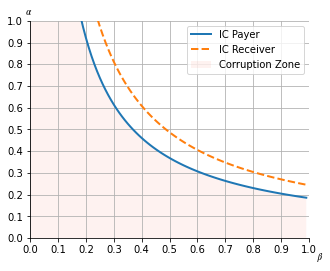

In [30]:
get_ICs()

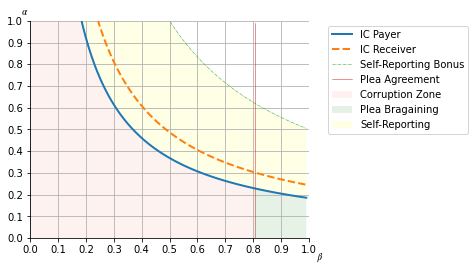

In [31]:
get_IC_star(R,P)

In [32]:
start_time = datetime.now()


outer_opearator()
    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

KeyboardInterrupt: 

## Individual Results


#### Plotting Corruption X Reporting heatmap

In [ ]:
vec1 =  get_heatmap_vec_pre(results.sigma, matrix.X_unique, matrix.D_unique)
vec2 =  get_heatmap_vec_post(results.sigma, matrix.X_unique, matrix.D_unique)
plot_heatmap(vec1,vec2)
player = get_otherplayer(player)
vec1 =  get_heatmap_vec_pre(results_2.sigma, matrix_2.X_unique, matrix_2.D_unique)
vec2 =  get_heatmap_vec_post(results_2.sigma, matrix_2.X_unique, matrix_2.D_unique)
plot_heatmap(vec1,vec2)

#### Plotting Path to Steady State


In [ ]:

plot_path_to_steady_state(matrix_2,results_2,50, 50)

In [ ]:
player = get_otherplayer(player)
plot_path_to_steady_state(matrix,results,50, 50)

#### Plotting the distribution of the steady state

In [ ]:
player = get_otherplayer(player)
histogram_stationary(results,matrix)

In [ ]:
player = get_otherplayer(player)
histogram_stationary(results_2,matrix_2)

## Society Results

The sampling method, Monte Carlo distribution estimation:


1 - Estimate the best strategy to both players $sigma_{payer}$ and $sigma_{receiver}$

2 - Assumes a distribution of the wealth in the economy (it is possible to differentiate richer from poorer countries).

3 - From fixed initial state ($s_nc$) for 5 periods (Alternative way is to assume an ad hoc distribution from the initial states);

4 - Keep the results and plot the distribution. 



In [ ]:
sample_1 =vector_sampler(200,5,matrix,matrix_2,results,results_2,0,1)
print('Benchmark')
histogram_sampling(sample_1, 'Normal')
sample_2 =vector_sampler(200,5,matrix,matrix_2,results,results_2,W_bar/4,1)
print('Richer')
histogram_sampling(sample_2,'Richer')
sample_3 =vector_sampler(200,5,matrix,matrix_2,results,results_2,-W_bar/4,1)
print('Poorer')
histogram_sampling(sample_3,'Poorer')

In [ ]:
print('Benchmark')
histogram_sampling_savings(sample_1, 'Normal')
print('Richer')
histogram_sampling_savings(sample_2, 'Richer')
print('Poorer')
histogram_sampling_savings(sample_3, 'Poorer')

# Conclusion

* As it was supposed to happen, the players pay bribes untill that their utility from current wealth is lower than the expected walth gained from corrupion.

* After this, they stop colluding at their wealth level.


# Further Studies

Set the problem for a complete game to run in a super-computer


# Refactioring Notes

1) The operators iterate the parameters and variables as global variables. Put the inside functions or objects;

2) Fix the player variable;

3) Simplify the feasibility rules;

4) Make sanctions only function of states. 

In [ ]:
start_time = datetime.now()

alphas = [0.1,0.1,0.1,0.1,0.2,0.2,0.2,0.2,0.3,0.3,0.3,0.3]
betas = [0.6,0.7,0.8,0.9,0.6,0.7,0.8,0.9,0.6,0.7,0.8,0.9]

for i,j in zip(alphas,betas):
    print('NEW ITERATION WITH ALPHA {} AND BETA {}'.format(i,j))
    matrix = False
    player = 'payer'
    alpha = i
    beta = j
    outer_opearator()
    vec1 =  get_heatmap_vec_pre(results.sigma, matrix.X_unique, matrix.D_unique)
    vec2 =  get_heatmap_vec_post(results.sigma, matrix.X_unique, matrix.D_unique)
    plot_heatmap(vec1,vec2)
    player = get_otherplayer(player)
    vec1 =  get_heatmap_vec_pre(results_2.sigma, matrix_2.X_unique, matrix_2.D_unique)
    vec2 =  get_heatmap_vec_post(results_2.sigma, matrix_2.X_unique, matrix_2.D_unique)
    plot_heatmap(vec1,vec2)
    player = get_otherplayer(player)
    plot_path_to_steady_state(matrix,results,50, 50)
    player = get_otherplayer(player)
    plot_path_to_steady_state(matrix_2,results_2,50, 50)
    player = get_otherplayer(player)
    histogram_stationary(results,matrix)
    player = get_otherplayer(player)
    histogram_stationary(results_2,matrix_2)
    histogram_stationary(results_2,matrix_2)
    sample_1 =vector_sampler(200,5,matrix,matrix_2,results,results_2,0,1)
    print('Benchmark')
    histogram_sampling(sample_1, 'Normal')
    sample_2 =vector_sampler(200,5,matrix,matrix_2,results,results_2,W_bar/4,1)
    print('Richer')
    histogram_sampling(sample_2,'Richer')
    sample_3 =vector_sampler(200,5,matrix,matrix_2,results,results_2,-W_bar/4,1)
    print('Poorer')
    histogram_sampling(sample_3,'Poorer')
    print('Benchmark')
    histogram_sampling_savings(sample_1, 'Normal')
    print('Richer')
    histogram_sampling_savings(sample_2, 'Richer')
    print('Poorer')
    histogram_sampling_savings(sample_3, 'Poorer')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

In [ ]:

start_time = datetime.now()

alpha = 0.1
beta = 0.6


Rs =[1,0.5,0.2,0.2,0,0,-0.5, -1]
rs =[1,0.5,0.5,0.5,0.4,0.4,0, 0]
Ps =[1,0.5,0.6,0.5,0.6,0.5,0.5, 0]
ps =[1,0.5,0.9,0.7,0.9,0.7,0.6, 0.5]

for i,j,k,l in zip(Rs,rs,Ps,ps):
    print('NEW ITERATION WITH R =  {}, r = {}, P = {} and p = {}'.format(i,j,k,l))
    matrix = False
    player = 'payer'
    R = i
    r = j
    P = k
    p = l
    get_IC_star(R,P)
    outer_opearator()
    vec1 =  get_heatmap_vec_pre(results.sigma, matrix.X_unique, matrix.D_unique)
    vec2 =  get_heatmap_vec_post(results.sigma, matrix.X_unique, matrix.D_unique)
    plot_heatmap(vec1,vec2)
    player = get_otherplayer(player)
    vec1 =  get_heatmap_vec_pre(results_2.sigma, matrix_2.X_unique, matrix_2.D_unique)
    vec2 =  get_heatmap_vec_post(results_2.sigma, matrix_2.X_unique, matrix_2.D_unique)
    plot_heatmap(vec1,vec2)
    player = get_otherplayer(player)
    plot_path_to_steady_state(matrix,results,50, 50)
    player = get_otherplayer(player)
    plot_path_to_steady_state(matrix_2,results_2,50, 50)
    player = get_otherplayer(player)
    histogram_stationary(results,matrix)
    player = get_otherplayer(player)
    histogram_stationary(results_2,matrix_2)
    histogram_stationary(results_2,matrix_2)
    sample_1 =vector_sampler(200,5,matrix,matrix_2,results,results_2,0,1)
    print('Benchmark')
    histogram_sampling(sample_1, 'Normal')
    sample_2 =vector_sampler(200,5,matrix,matrix_2,results,results_2,W_bar/4,1)
    print('Richer')
    histogram_sampling(sample_2,'Richer')
    sample_3 =vector_sampler(200,5,matrix,matrix_2,results,results_2,-W_bar/4,1)
    print('Poorer')
    histogram_sampling(sample_3,'Poorer')
    print('Benchmark')
    histogram_sampling_savings(sample_1, 'Normal')
    print('Richer')
    histogram_sampling_savings(sample_2, 'Richer')
    print('Poorer')
    histogram_sampling_savings(sample_3, 'Poorer')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


In [ ]:

start_time = datetime.now()

R = 0.1
r = 0.5
P = 0.6
p = 0.9

irs = [0.02,0.05,0.1,0.16,0.2,0.3]

for i in irs:
    print('NEW ITERATION WITH Interests {}'.format(i))
    matrix = False
    player = 'payer'
    ir = i
    outer_opearator()
    vec1 =  get_heatmap_vec_pre(results.sigma, matrix.X_unique, matrix.D_unique)
    vec2 =  get_heatmap_vec_post(results.sigma, matrix.X_unique, matrix.D_unique)
    plot_heatmap(vec1,vec2)
    player = get_otherplayer(player)
    vec1 =  get_heatmap_vec_pre(results_2.sigma, matrix_2.X_unique, matrix_2.D_unique)
    vec2 =  get_heatmap_vec_post(results_2.sigma, matrix_2.X_unique, matrix_2.D_unique)
    plot_heatmap(vec1,vec2)
    player = get_otherplayer(player)
    plot_path_to_steady_state(matrix,results,50, 50)
    player = get_otherplayer(player)
    plot_path_to_steady_state(matrix_2,results_2,50, 50)
    player = get_otherplayer(player)
    histogram_stationary(results,matrix)
    player = get_otherplayer(player)
    histogram_stationary(results_2,matrix_2)
    histogram_stationary(results_2,matrix_2)
    sample_1 =vector_sampler(200,5,matrix,matrix_2,results,results_2,0,1)
    print('Benchmark')
    histogram_sampling(sample_1, 'Normal')
    sample_2 =vector_sampler(200,5,matrix,matrix_2,results,results_2,W_bar/4,1)
    print('Richer')
    histogram_sampling(sample_2,'Richer')
    sample_3 =vector_sampler(200,5,matrix,matrix_2,results,results_2,-W_bar/4,1)
    print('Poorer')
    histogram_sampling(sample_3,'Poorer')
    print('Benchmark')
    histogram_sampling_savings(sample_1, 'Normal')
    print('Richer')
    histogram_sampling_savings(sample_2, 'Richer')
    print('Poorer')
    histogram_sampling_savings(sample_3, 'Poorer')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


In [ ]:

start_time = datetime.now()

ir = 0.05


a =[2,4,3,5,6,6,10,15,20,8]
b =[1,1,2,3,3,4,5,10,12,2]
c_b =[0,0,0,1,1,1,5,2,0]
f =[2,4,3,5,6,6,10,15,20,8]

for i,j,k,l in zip(a,b,c_b,f):
    print('NEW ITERATION WITH a =  {}, b = {}, c_b = {} and f = {}'.format(i,j,k,l))
    matrix = False
    player = 'payer'
    a = i
    b = j
    c_b = k
    f = l
    get_IC_star(R,P)
    outer_opearator()
    print('RESULTS IN EQUILIBRIUM')
    vec1 =  get_heatmap_vec_pre(results.sigma, matrix.X_unique, matrix.D_unique)
    vec2 =  get_heatmap_vec_post(results.sigma, matrix.X_unique, matrix.D_unique)
    plot_heatmap(vec1,vec2)
    player = get_otherplayer(player)
    vec1 =  get_heatmap_vec_pre(results_2.sigma, matrix_2.X_unique, matrix_2.D_unique)
    vec2 =  get_heatmap_vec_post(results_2.sigma, matrix_2.X_unique, matrix_2.D_unique)
    plot_heatmap(vec1,vec2)
    player = get_otherplayer(player)
    plot_path_to_steady_state(matrix,results,50, 50)
    player = get_otherplayer(player)
    plot_path_to_steady_state(matrix_2,results_2,50, 50)
    player = get_otherplayer(player)
    histogram_stationary(results,matrix)
    player = get_otherplayer(player)
    histogram_stationary(results_2,matrix_2)
    histogram_stationary(results_2,matrix_2)
    sample_1 =vector_sampler(200,5,matrix,matrix_2,results,results_2,0,1)
    print('Benchmark')
    histogram_sampling(sample_1, 'Normal')
    sample_2 =vector_sampler(200,5,matrix,matrix_2,results,results_2,W_bar/4,1)
    print('Richer')
    histogram_sampling(sample_2,'Richer')
    sample_3 =vector_sampler(200,5,matrix,matrix_2,results,results_2,-W_bar/4,1)
    print('Poorer')
    histogram_sampling(sample_3,'Poorer')
    print('Benchmark')
    histogram_sampling_savings(sample_1, 'Normal')
    print('Richer')
    histogram_sampling_savings(sample_2, 'Richer')
    print('Poorer')
    histogram_sampling_savings(sample_3, 'Poorer')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


In [ ]:
# !zip -r /content/Plottings.zip /content/Plottings